In [4]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
#from ipynb.fs.full.All_Functions import GetPopParams
#from ipynb.fs.full.All_Functions import GetPopParamsOmega
#from ipynb.fs.full.All_Functions import GetVLIndParams
#from ipynb.fs.full.All_Functions import RandVLIndParams
#from ipynb.fs.full.All_Functions import RandVLParams
#from ipynb.fs.full.All_Functions import PKPDParams
#from ipynb.fs.full.All_Functions import Cohort_Prep
#from ipynb.fs.full.All_Functions import VLModel
#from ipynb.fs.full.All_Functions import VLPKPD
#from ipynb.fs.full.All_Functions import PK_Model
#from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
#from ipynb.fs.full.All_Functions import SimulateTreatment
#from ipynb.fs.full.All_Functions import Trial_Simulation
#from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
#from ipynb.fs.full.All_Functions import SimulateTreatmentPK
#from ipynb.fs.full.All_Functions import TreatmentImpact
#from ipynb.fs.full.All_Functions import CI_Calc
#from ipynb.fs.full.All_Functions import ParamsPrep
%matplotlib inline

In [5]:
def StandardDoseTimeSim(TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, tstart, in enumerate(TrtmntStrtDay):
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X.append(np.log10(np.maximum(V,500)))
       # X[idi][X[idi]==2]=1
        times.append(t)
    return X, times

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
##  --- Within-host parameters


data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_7BroadVariants.csv'
Data_df = pd.read_csv(data_file)
Data_Omicron_symp = Data_df[(Data_df.cat_Lineage7variants=='Omicron')*(Data_df.cat_SympEver!='No')]

IDs_Symp = Data_Omicron_symp.ID.unique()
print(len(IDs_Symp))

IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)
## --------------------- PK parameters -----------------------------
Indparameters_MPV_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/MPVestimatedIndividualParameters.txt'
Popparameters_MPV_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/MPVpopulationParameters.txt'
#data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/PK-PD/NBACohort/NBA_FreqTestersAppendNegativesToAll.csv'



Indparameters_MPV = pd.read_csv(Indparameters_MPV_file)
Popparameters_MPV = pd.read_csv(Popparameters_MPV_file)
#print(Popparameters_MPV)




822


In [8]:
data_File = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Data/NBA_Panoramic_PLATCOV_MPV.csv'
Data_df = pd.read_csv(data_File)

NBA = Data_df[Data_df.cat_Cohort == 'NBA']
PLATCOV_Cntrl = Data_df[Data_df.cat_Cohort == 'PLATCOV']
PLATCOV_Trtmnt = Data_df[Data_df.cat_Cohort == 'PLATCOV_trtmnt']
Panoramic_Cntrl= Data_df[Data_df.cat_Cohort == 'Panoramic']
Panoramic_Trtmnt= Data_df[Data_df.cat_Cohort == 'Panoramic_trtmnt']

IDs_Tot = Data_df.ID.unique()
IDs_NBA = NBA.ID.unique()
IDs_Platcov_Cntrl = PLATCOV_Cntrl.ID.unique()
IDs_Platcov_trtmnt = PLATCOV_Trtmnt.ID.unique()

IDs_Panoramic_Cntrl = Panoramic_Cntrl.ID.unique()
IDs_Panoramic_trtmnt = Panoramic_Trtmnt.ID.unique()


In [10]:
#calculating viral load drop from baseline in control arm
VL_drop_Cntrl = []
for id in IDs_Panoramic_Cntrl:
    for t in [1,2,3,4,5,6, 13]:
        if 0 in Panoramic_Cntrl[(Panoramic_Cntrl.ID == id)].time.unique() and t not in Panoramic_Cntrl[(Panoramic_Cntrl.ID == id)].time.unique():
            if t-1 in Panoramic_Cntrl[(Panoramic_Cntrl.ID == id)].time.unique():
                VL_drop_Cntrl.append({'ID': id, 'time': t, 
                                      'VL_Drop':(Panoramic_Cntrl[(Panoramic_Cntrl.ID == id) & (Panoramic_Cntrl.time==t-1)].y.values[0])-(Panoramic_Cntrl[(Panoramic_Cntrl.ID == id) & (Panoramic_Cntrl.time==0)].y.values[0])})
            elif t+1 in Panoramic_Cntrl[(Panoramic_Cntrl.ID == id)].time.unique():
                VL_drop_Cntrl.append({'ID': id, 'time': t, 
                                      'VL_Drop':(Panoramic_Cntrl[(Panoramic_Cntrl.ID == id) & (Panoramic_Cntrl.time==t+1)].y.values[0])-(Panoramic_Cntrl[(Panoramic_Cntrl.ID == id) & (Panoramic_Cntrl.time==0)].y.values[0])})
        if 0 in Panoramic_Cntrl[(Panoramic_Cntrl.ID == id)].time.unique() and t in Panoramic_Cntrl[(Panoramic_Cntrl.ID == id)].time.unique():

            VL_drop_Cntrl.append({'ID': id, 'time': t, 
                                  'VL_Drop':Panoramic_Cntrl[(Panoramic_Cntrl.ID == id) & (Panoramic_Cntrl.time==t)].y.values[0]-Panoramic_Cntrl[(Panoramic_Cntrl.ID == id) & (Panoramic_Cntrl.time==0)].y.values[0]})
 
VL_drop_Cntrl = pd.DataFrame(VL_drop_Cntrl)

In [12]:
#calculating viral load drop from baseline in treatment arm
Panoramic_Trtmnt_NoNan= Panoramic_Trtmnt[Panoramic_Trtmnt['y'].notna()]
VL_drop_Trtmnt = []
for id in IDs_Panoramic_trtmnt:
    for t in [1,2,3,4,5,6, 13]:
        if 0 in Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id)].time.unique() and t not in Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id)].time.unique():
            if t-1 in Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id)].time.unique():
                VL_drop_Trtmnt.append({'ID': id, 'time': t, 
                                      'VL_Drop':(Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id) & (Panoramic_Trtmnt_NoNan.time==t-1)].y.values[0])-(Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id) & (Panoramic_Trtmnt_NoNan.time==0)].y.values[0])})
            elif t+1 in Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id)].time.unique():
                VL_drop_Trtmnt.append({'ID': id, 'time': t, 
                                      'VL_Drop':(Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id) & (Panoramic_Trtmnt_NoNan.time==t+1)].y.values[0])-(Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id) & (Panoramic_Trtmnt_NoNan.time==0)].y.values[0])})
        elif 0 in Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id)].time.unique() and t in Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id)].time.unique():

            VL_drop_Trtmnt.append({'ID': id, 'time': t, 
                                  'VL_Drop':(Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id) & (Panoramic_Trtmnt_NoNan.time==t)].y.values[0])-(Panoramic_Trtmnt_NoNan[(Panoramic_Trtmnt_NoNan.ID == id) & (Panoramic_Trtmnt_NoNan.time==0)].y.values[0])})
 
VL_drop_Trtmnt = pd.DataFrame(VL_drop_Trtmnt)

In [10]:
Mean_VL_Drop_Cntrl=[0]
std_VL_Drop_Cntrl=[0]
Mean_VL_Drop_Trtmnt=[0]
std_VL_Drop_Trtmnt=[0]
for t in [1,2,3,4,5,6, 13]:
    Mean_VL_Drop_Cntrl.append(np.mean(VL_drop_Cntrl[VL_drop_Cntrl.time==t].VL_Drop))
    std_VL_Drop_Cntrl.append(np.std(VL_drop_Cntrl[VL_drop_Cntrl.time==t].VL_Drop))
    Mean_VL_Drop_Trtmnt.append(np.mean(VL_drop_Trtmnt[VL_drop_Trtmnt.time==t].VL_Drop))
    std_VL_Drop_Trtmnt.append(np.std(VL_drop_Trtmnt[VL_drop_Trtmnt.time==t].VL_Drop))

In [13]:
Mean_VL_Drop_Cntrl[5]-Mean_VL_Drop_Trtmnt[5]

0.9400238925979725

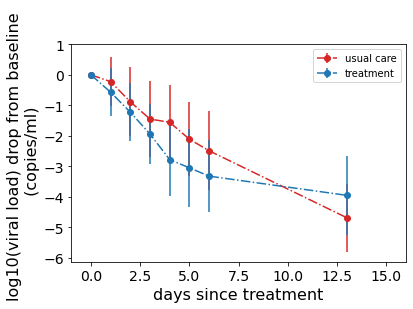

In [17]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.errorbar([0,1,2,3,4,5,6, 13],  Mean_VL_Drop_Cntrl,yerr = std_VL_Drop_Cntrl, fmt = '-.o', color = 'tab:red', label = 'usual care')
ax1.errorbar([0,1,2,3,4,5,6, 13], Mean_VL_Drop_Trtmnt, yerr =std_VL_Drop_Trtmnt, fmt = '-.o', color = 'tab:blue', label = 'treatment')
ax1.set_ylabel("log10(viral load) drop from baseline \n (copies/ml)", fontsize=16)
ax1.tick_params(axis="y", labelsize = 14)
ax1.set_xlabel('days since treatment', fontsize=16)
ax1.tick_params(axis="x", labelsize = 14)
ax1.set_yticks([1, 0,-1,-2,-3,-4,-5, -6])
ax1.set_xlim([-1,16])
ax1.legend()

In [13]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [14]:
def GetPopParams(Popparameters, dose):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows

    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    cols = list(Popparameters.parameter)
   # print(cols)
    pid_params = Popparameters
  #  print(pid_params.value)
    values = []
    keys = []
    for i, c in enumerate(cols):
        if 'pop' in c:
            k = c.split('_')[0]
            keys.append(k)
         #   print(keys)
            v = pid_params.value[i]
            values.append(v)
         #   print(values)
            
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]
    if 'alpha' in keys:
        i = keys.index('alpha')
        j = keys.index('kPL')
        values[j] = values[j]*dose**values[i]

    params = dict(zip(keys, values))
    return params

In [15]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [16]:
def PKPDParams(Popparameters, GetPopParams, GetParamsOmega, Emax, IC50, Hill, dose, PDOm):
    
    param_Order = ['ka', 'k12', 'k21', 'kcl', 'Vol', 'Emax', 'IC50', 'Hill']
    PKparams = GetPopParams(Popparameters, dose)
    PKparams_Val = PKparams['ka'], PKparams['kPL'], PKparams['kLP'], PKparams['kCl'],PKparams['Vol']
    PDparams = Emax, IC50, Hill
    PKPDparams = np.hstack((PKparams_Val, PDparams))
    
   # PKOm = GetParamsOmega(Popparameters, dose)
   # PKOm_Val = PKOm['ka'], PKOm['kPL'], PKOm['kLP'], PKOm['kCl'],PKOm['Vol']
    PKOm_Val = 0, 0, 0, 0, 0
    PKPDOm = np.hstack((PKOm_Val, PDOm))
    eta = np.random.normal(np.zeros(len(PKPDOm)), PKPDOm, len(PKPDOm))
    PKPDInd = PKPDparams*np.exp(eta)
    return dict(zip(param_Order, PKPDInd))

In [17]:
def VLPKPD(y, t, beta, phi, rho, k, delta, m, pi, c,tAI, ka, k12, kcl, k21,Vol, MolMass,E_max, IC50, Hill_Coeff):
    T,R,E,I,V,Vm, Ag, A1, A2 = y
    
    # PK model 
    dAg = -ka*Ag
    dA1 = ka*Ag+k21*A2-(kcl+k12)*A1
    dA2 = k12*A1-k21*A2   
    
    # PD model 
    conc = np.maximum(A1, 10**-8)*10**6/Vol/MolMass # # convert to from nanogram/mL to micromolar
    epsM = np.divide(np.multiply(E_max,np.power(conc,Hill_Coeff)),(np.power(IC50, Hill_Coeff)+np.power(conc,Hill_Coeff)))
        
    # within-host treatment model
    if t > tAI:
        m_AI = m
    else:
        m_AI = 0
    
    
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*I - m_AI*I
    if I>=1:
        ddt_V = (1-epsM)*pi*I-c*V
        ddt_Vm = epsM*pi*I-c*Vm
    else:
        ddt_V = -c*V
        ddt_Vm = -c*Vm

    return  ddt_T, ddt_R, ddt_E, ddt_I, ddt_V, ddt_Vm, dAg, dA1, dA2


In [18]:
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
    
        t_end = 30 #duration of simulation 30 days after symptom onset. 
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)

        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, 
                                MolMass)
        return t, y, dosetimes

In [19]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Vm, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V+Vm,100))
            v[v==np.log10(100)]=np.log10(50)
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == np.log10(50)) & (t>Tmax))]

            while (len(PS_Duration) != 0 and PS_Duration[0]<5):  #to assure duration of infection after symptom is greater than 5 days
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Vm, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V+Vm,100))
                v[v==np.log10(100)]=np.log10(50)
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == np.log10(50)) & (t>Tmax))]
    
    return params, param_dict

In [20]:

def SimulateTreatment(VLPKPD, init, tzero, dt, tend, params, PKPDInd, dose, dosetimes, PotRed, MolMass):
    #Nirmatrelvir PD parameters
    E_max = PKPDInd['Emax']
    Hill_Coeff = PKPDInd['Hill']
    IC50 = PotRed*PKPDInd['IC50']

    #Nirmatrelvir PK Parameters for each individual
    ka = PKPDInd['ka']
    k12 = PKPDInd['k12']
    k21 = PKPDInd['k21']
    kcl = PKPDInd['kcl']
    Vol = PKPDInd['Vol']
    params_local = params.copy()
    params_local.extend([ka, k12, kcl, k21,Vol, MolMass, E_max, IC50, Hill_Coeff])
    args = tuple(params_local)
    if tzero==dosetimes[0]:
        for j in range(0,len(dosetimes)-1):
            init[6] = init[6] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            init = ytemp[-1,:].T
            if j==0:
                y= ytemp.copy()
                t= ttemp.copy()
            else:
                y = np.concatenate((y,ytemp), axis=0)
                t = np.concatenate((t,ttemp))
         #   print(y.T[4])
    else:       
        
        # simulate infection from tzero up to 1st dose
        t = np.arange(tzero, dosetimes[0],dt)
        # simulate using scipy integrate
        y = spi.odeint(VLPKPD, init, t, args = args)
   
        ytemp = y.copy()
      #  print(ytemp.T[0])
        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init = ytemp[-1,:].T
            init[6] = init[6] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
        
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
         #   print(ytemp.T[4])
            t=np.concatenate((t,ttemp))
            y=np.concatenate((y,ytemp),axis=0)        
    #simulate until tend
    init = ytemp[-1,:].T
    init[6] = init[6] + dose 
    ttemp = np.arange(dosetimes[-1],tend,dt)
    ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
    t=np.concatenate((t,ttemp))
    y=np.concatenate((y,ytemp),axis=0)  
    return t, y

In [21]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

0    4.61
Name: Mean, dtype: float64

In [22]:
# Molnupiravir in vitro IC50
Emax = 1.00
IC50 = 0.177 #uMol
Hill = 2.05
PDOm = 0, 0.0066, 0.22
MolMass = 329.31   #g/Mol
dose =800

In [23]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    Vm_0 = 0
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0, Vm_0]

In [24]:
strtday = np.random.normal(loc=np.log10((2.5)/(5-2.5)), scale=1.12, size=400)
TreatmntStrtDay = (5*np.exp(strtday))/(1+np.exp(strtday))
np.mean(np.round(TreatmntStrtDay, 0))

2.47

## control arm

In [212]:
dose = 0
Num= 400
Median_drop_VL_TotPop_cntrl_runs = []
Mean_drop_VL_TotPop_cntrl_runs = []
drop_VL_runs_cntrl = []
VL_Base = []
R2_run=[]

fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})
PotRed=np.ones(Num)

for run in range(0,10):
    print(run)
    Mean_drop_VL_TotPop_cntrl = []
    Median_drop_VL_TotPop_cntrl = []
    drop_VL = []
    Baseline_VL =[]
    AUC = []
    AUC_baseTo16 = []
    Cohort = Cohort_Prep(IDs_Symp, Num)
    #Cohort_Prep(IDs_Symp, Num)
#TreatmntStrtDay = random.choices(range(1,6), k=Num) #treatment starting within 5 days of symptom onset (day 1 through 5)
    strtday = np.random.normal(loc=np.log10((2.5)/(5-2.5)), scale=1.12, size=400)
    TreatmntStrtDay = np.round((5*np.exp(strtday))/(1+np.exp(strtday)),0)
    VLInd, PKPD_params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose = 8*10**8) #dose in ng
    VLInd, param_dict = Incubation_Prep(Data_Omicron_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    
    for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):
        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_params[idi], param_dict[idi], 
                                                     PotRed[idi], MolMass, dose, SetInit, VLPKPD, 
                                                 TreatmentLength = 5, TreatmentFrequency = 0.5) #dose in mg
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,100))
        X[X==np.log10(100)]=np.log10(50)
        AUC.append(auc(t,X))
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay)[0][0]+16000
        AUC_baseTo16.append(auc(t[tstart:tend], X[tstart:tend]))
        drop_VL.append(X[tstart:tend]-X[tstart])
        Baseline_VL.append(X[tstart])
       
    Mean_drop_VL_TotPop_cntrl=np.mean(drop_VL, axis=0)
    Median_drop_VL_TotPop_cntrl=np.median(drop_VL, axis=0)
    t1 = np.argwhere(np.linspace(0, 15.999, 16000)>=1)[0][0]
    t2 = np.argwhere(np.linspace(0, 15.999, 16000)>=2)[0][0]
    t3 = np.argwhere(np.linspace(0, 15.999, 16000)>=3)[0][0]
    t4 = np.argwhere(np.linspace(0, 15.999, 16000)>=4)[0][0]
    t5 = np.argwhere(np.linspace(0, 15.999, 16000)>=5)[0][0]
    t6 = np.argwhere(np.linspace(0, 15.999, 16000)>=6)[0][0]
   
    t13 = np.argwhere(np.linspace(0, 15.999, 16000)>=13)[0][0]   

    r2 = r2_score(Mean_VL_Drop_Cntrl, 
              [Mean_drop_VL_TotPop_cntrl[0], Mean_drop_VL_TotPop_cntrl[t1], Mean_drop_VL_TotPop_cntrl[t2], 
               Mean_drop_VL_TotPop_cntrl[t3],Mean_drop_VL_TotPop_cntrl[t4], Mean_drop_VL_TotPop_cntrl[t5],
               Mean_drop_VL_TotPop_cntrl[t6], Mean_drop_VL_TotPop_cntrl[t13]])
    #,Mean_drop_VL_TotPop_cntrl[t13]
    drop_VL_runs_cntrl.append(drop_VL)
    Median_drop_VL_TotPop_cntrl_runs.append(Median_drop_VL_TotPop_cntrl)
    Mean_drop_VL_TotPop_cntrl_runs.append(Mean_drop_VL_TotPop_cntrl)
    VL_Base.append(Baseline_VL)
    R2_run.append(r2)
    


0
1
2
3
4
5
6
7
8
9


<Figure size 576x360 with 0 Axes>

In [94]:
pickle.dump(drop_VL_runs_cntrl[7], open('TotVdrop_Cntrl_PANORAMIC.pickle', 'wb')) 
pickle.dump(VL_Base[7], open('Baseline_Cntrl_PANORAMIC.pickle', 'wb')) 
#pickle.dump(AUC, open('AUC_TotVdrop_Cntrl_PANORAMIC.pickle', 'wb')) 
#pickle.dump(AUC_baseTo16, open('AUC_baseTo16_TotVdrop_Cntrl_PANORAMIC.pickle', 'wb')) 

In [213]:
np.round(R2_run,2)

array([0.96, 0.96, 0.96, 0.98, 0.96, 0.94, 0.95, 0.96, 0.94, 0.96])

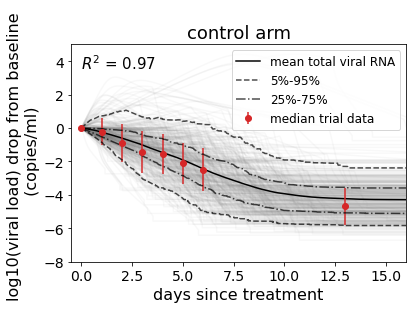

In [124]:
fig, ax1 = plt.subplots(figsize=(6, 4))

#i= np.argwhere(np.round(R2_run,2) ==st.mode(np.round(R2_run,2))[0])[0][0]
i=1
for idi in range(0,400):
    ax1.plot(np.linspace(0, 15.999, 16000),drop_VL_runs_cntrl[i][idi], color = 'grey', alpha = 0.05)
perc_5 = np.percentile(drop_VL_runs_cntrl[i], 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 15.999, 16000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 15.999, 100000))
perc_95 = np.percentile(drop_VL_runs_cntrl[i], 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 15.999, 16000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 15.999, 100000))
perc_25 = np.percentile(drop_VL_runs_cntrl[i], 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 15.999, 16000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 15.999, 100000))
perc_75 = np.percentile(drop_VL_runs_cntrl[i], 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 15.999, 16000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 15.999, 100000))
t1 = np.argwhere(np.linspace(0, 15.999, 16000)>=1)[0][0]
t2 = np.argwhere(np.linspace(0, 15.999, 16000)>=2)[0][0]
t3 = np.argwhere(np.linspace(0, 15.999, 16000)>=3)[0][0]
t4 = np.argwhere(np.linspace(0, 15.999, 16000)>=4)[0][0]
t5 = np.argwhere(np.linspace(0, 15.999, 16000)>=5)[0][0]
t6 = np.argwhere(np.linspace(0, 15.999, 16000)>=6)[0][0]
t13 = np.argwhere(np.linspace(0, 15.999, 16000)>=13)[0][0]  



ax1.plot(np.linspace(0, 15.999, 16000), Mean_drop_VL_TotPop_cntrl_runs[i], color = 'k', label = 'mean total viral RNA')
ax1.errorbar([0,1,2,3,4,5,6,13], Mean_VL_Drop_Cntrl,yerr = std_VL_Drop_Cntrl, fmt = 'o', color = 'tab:red', label = 'median trial data')
ax1.plot(np.linspace(0, 15.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
ax1.plot(np.linspace(0, 15.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
ax1.plot(np.linspace(0, 15.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
ax1.plot(np.linspace(0, 15.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)
ax1.text(0,3.5,'$R^2$ = ' + str(round(R2_run[i],2)))
ax1.set_ylabel("log10(viral load) drop from baseline \n (copies/ml)", fontsize=16)
ax1.tick_params(axis="y", labelsize = 14)
ax1.set_xlabel('days since treatment', fontsize=16)
ax1.tick_params(axis="x", labelsize = 14)
ax1.set_ylim([-8, 5])
ax1.set_xlim([-.5, 16])
ax1.set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
ax1.set_title('control arm')
ax1.legend(fontsize="12")
#plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/controlEPIC.png')

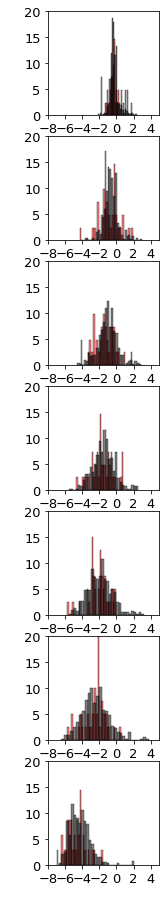

In [125]:
fig = plt.figure(figsize = (2,18))
plt.rcParams.update({'font.size': 13})
P_value = []
for it, t , tindex in zip(range(0, 7), VL_drop_Cntrl.time.unique(), [t1, t2, t3, t4, t5, t6, t13]):
    Sim = drop_VL_runs_cntrl[i]
    day = [X[tindex] for X in Sim]
    plt.subplot(8,1, 1+it)
    sns.histplot(VL_drop_Cntrl[VL_drop_Cntrl.time == t].VL_Drop, bins=30, color = 'r', stat = 'percent', kde=False, alpha = 0.5, label = 'data')
    sns.histplot(day, bins = 30, color = 'k', stat = 'percent', kde=False, alpha = 0.5, label = 'simulation')
    start, p = st.kstest(VL_drop_Cntrl[VL_drop_Cntrl.time == t].VL_Drop, day)
    P_value.append(p)
   # if p>0.01:
   #     plt.text(1,15, 'p='+str(round(p,2)), fontsize = 15)
   # else:
   #     plt.text(1,15, 'p='+str(round(p,4)), fontsize = 15)
   # if it==0:
      #  plt.legend(loc = (0.75, 0.5))
      #  plt.title('control arm')
    #if it!=3:
    plt.ylabel(' ')
 #   if it!=7:
    plt.xlabel(' ')
  #  else:
    #    plt.xlabel('log_10(VL) drop from baseline')
    plt.xlim([-8,5])   
    plt.xticks(np.linspace(-8,4,7))
    plt.ylim([0,20])
    plt.yticks(np.linspace(0,20,5))
    #sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
#plt.tight_layout(pad=0.002)

In [129]:
Adj_P = []
Adj_P=np.round(st.false_discovery_control(P_value),4)
Adj_P

array([0.5291, 0.0146, 0.094 , 0.7868, 0.7868, 0.5291, 0.1203])

## estimating paf

In [253]:
dose = 800
Num= 400

R2=[]
R2_full = []
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})
PotRed=np.ones(Num)

for run in range(0,10):
    r2 = []
    r2_full= []
    print(run)
    Mean_drop_VL_TotPop_trtmnt = []
    drop_VL = []
    Cohort = Cohort_Prep(IDs_Symp, Num)
#TreatmntStrtDay = random.choices(range(1,6), k=Num) #treatment starting within 5 days of symptom onset (day 1 through 5)
    strtday = np.random.normal(loc=np.log10((2.4)/(5-2.4)), scale=0.78, size=400)
    TreatmntStrtDay = np.round((5*np.exp(strtday))/(1+np.exp(strtday)),0)
    VLInd, PKPD_params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose = 8*10**8) #dose in ng
    VLInd, param_dict = Incubation_Prep(Data_Omicron_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    
    for PotReduc in np.linspace(-4, 1, 50):
        #print("   " + str(np.round(10**PotReduc,4)))
        Mean_drop_VL_TotPop_trtmnt = []
        drop_VL = []
        for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):
            t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_params[idi], param_dict[idi], 
                                                     np.round(10**PotReduc,6), MolMass, dose, SetInit, VLPKPD, 
                                                 TreatmentLength = 5, TreatmentFrequency = 0.5) #dose in mg
            T,R,E,I,V, Vm, Ag, A1, A2 = y.T
            X = np.log10(np.maximum(V+Vm,100))
            X[X==np.log10(100)]=np.log10(50)
            tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
            tend = np.argwhere(t>=TrtmntStrtDay)[0][0]+16000
            drop_VL.append(X[tstart:tend]-X[tstart])
       
        Mean_drop_VL_TotPop_trtmnt=np.mean(drop_VL, axis=0)
        Median_drop_VL_TotPop_trtmnt=np.median(drop_VL, axis=0)
        t1 = np.argwhere(np.linspace(0, 15.999, 16000)>=1)[0][0]
        t2 = np.argwhere(np.linspace(0, 15.999, 16000)>=2)[0][0]
        t3 = np.argwhere(np.linspace(0, 15.999, 16000)>=3)[0][0]
        t4 = np.argwhere(np.linspace(0, 15.999, 16000)>=4)[0][0]
        t5 = np.argwhere(np.linspace(0, 15.999, 16000)>=5)[0][0]
        t6 = np.argwhere(np.linspace(0, 15.999, 16000)>=6)[0][0]
        t13 = np.argwhere(np.linspace(0, 15.999, 16000)>=13)[0][0]    

        r2.append(r2_score(Mean_VL_Drop_Trtmnt[0:7], 
              [Mean_drop_VL_TotPop_trtmnt[0], Mean_drop_VL_TotPop_trtmnt[t1], Mean_drop_VL_TotPop_trtmnt[t2], 
               Mean_drop_VL_TotPop_trtmnt[t3],Mean_drop_VL_TotPop_trtmnt[t4], Mean_drop_VL_TotPop_trtmnt[t5],
               Mean_drop_VL_TotPop_trtmnt[t6]]))
       # ,Median_drop_VL_TotPop_trtmnt[t13]
   #     print(r2[-1])
        r2_full.append(r2_score(Mean_VL_Drop_Trtmnt, 
              [Mean_drop_VL_TotPop_trtmnt[0], Mean_drop_VL_TotPop_trtmnt[t1], Mean_drop_VL_TotPop_trtmnt[t2], 
               Mean_drop_VL_TotPop_trtmnt[t3],Mean_drop_VL_TotPop_trtmnt[t4], Mean_drop_VL_TotPop_trtmnt[t5],
               Mean_drop_VL_TotPop_trtmnt[t6],Mean_drop_VL_TotPop_trtmnt[t13]]))
       # print(r2)
    R2.append(r2)
    R2_full.append(r2_full)
   # print(np.max(R2[-1]))
   # print(np.max(R2_full[-1]))
    


0
1
2
3
4
5
6
7
8
9


<Figure size 576x360 with 0 Axes>

In [23]:
R2 = pickle.load(open('R2_Emax=1_Panoramic.pickle', 'rb'))

Text(0, 0.5, '$R^2$ of the treatment arm \n fit to data')

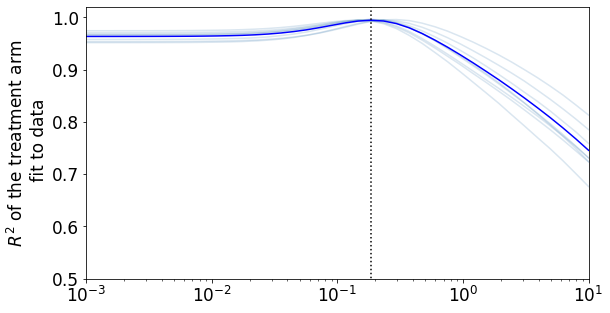

In [254]:
fig = plt.figure(figsize = (9,5))
plt.rcParams.update({'font.size': 17})
prf=[]
prf_max =[]
for run in np.arange(0,8):
    plt.semilogx(10**np.linspace(-4, 1, 50), R2[run], color= 'steelblue', alpha = 0.2)
    
    prf_index= np.argwhere(np.asarray(np.round(R2[run],2))<=[0.9])
    prf_index_max= np.argwhere(R2[run]==max(R2[run]))
    prf.append(10**np.linspace(-4, 1, 50)[prf_index[0][0]]) 
    prf_max.append(10**np.linspace(-4, 1, 50)[prf_index_max[0][0]]) 
R2_Ave=np.mean(R2, axis=0)
plt.semilogx(10**np.linspace(-4, 1, 50), R2_Ave, color= 'b')
plt.vlines(x = np.median(prf_max), ymin = 0.3, ymax = 1.5, color = 'k', linestyle = 'dotted')
#plt.vlines(x = np.median(prf), ymin = 0.3, ymax = 1.5, color = 'k', linestyle = 'dotted')
#plt.xticks([0.001, 0.01, 0.1, 10**np.linspace(-4, 1, 50)[prf_index[0][0]], 1, 10, 100])
plt.ylim([0.5, 1.02])
plt.xlim([0.001,10])
plt.ylabel('$R^2$ of the treatment arm \n fit to data')

#fig.savefig('PaperFigs/R2.svg')

In [255]:
np.mean(prf_max)

0.1896532356693883

In [256]:
np.std(prf_max)

0.04849777464468235

## treatment arm

In [257]:
dose = 800
Num= 400
Mean_drop_VL_TotPop_trtmnt_runs = []
drop_VL_runs_trtmnt = []
Mean_drop_VL_active_trtmnt_runs = []
drop_VL_active_runs_trtmnt = []
R2_run_trtmnt=[]
Cohort = []
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})
PotRed=0.19*np.ones(Num)

for run in range(0,10):
    print(run)
    Mean_drop_VL_TotPop_trtmnt = []
    drop_VL = []
    Mean_drop_VL_active_trtmnt = []
    drop_VL_active = []
    Cohort.append(Cohort_Prep(IDs_Symp, Num))
    strtday = np.random.normal(loc=np.log10((2.4)/(5-2.4)), scale=0.78, size=400)
    TreatmntStrtDay = np.round((5*np.exp(strtday))/(1+np.exp(strtday)),0)
    VLInd, PKPD_params, param_dict = ParamsPrep(Cohort[run], 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose = 8*10**8) #dose in ng
    VLInd, param_dict = Incubation_Prep(Data_Omicron_symp, Incubation_params, Cohort[run],TreatmntStrtDay, VLInd, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    
    for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort[run], TreatmntStrtDay):
        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_params[idi], param_dict[idi], 
                                                     PotRed[idi], MolMass, dose, SetInit, VLPKPD, 
                                                 TreatmentLength = 5, TreatmentFrequency = 0.5) #dose in mg
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,100))
        X_active = np.log10(np.maximum(V,100))
        X[X==np.log10(100)]=np.log10(50)
        X_active[X_active==np.log10(100)]=np.log10(50)
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay)[0][0]+16000
        drop_VL.append(X[tstart:tend]-X[tstart])
        drop_VL_active.append(X_active[tstart:tend]-X_active[tstart])
       
    Mean_drop_VL_TotPop_trtmnt=np.mean(drop_VL, axis=0)
    Mean_drop_VL_active_trtmnt=np.mean(drop_VL_active, axis=0)
    t1 = np.argwhere(np.linspace(0, 15.999, 16000)>=1)[0][0]
    t2 = np.argwhere(np.linspace(0, 15.999, 16000)>=2)[0][0]
    t3 = np.argwhere(np.linspace(0, 15.999, 16000)>=3)[0][0]
    t4 = np.argwhere(np.linspace(0, 15.999, 16000)>=4)[0][0]
    t5 = np.argwhere(np.linspace(0, 15.999, 16000)>=5)[0][0]
    t6 = np.argwhere(np.linspace(0, 15.999, 16000)>=6)[0][0]
    t13 = np.argwhere(np.linspace(0, 15.999, 16000)>=13)[0][0]   

    r2 = r2_score(Mean_VL_Drop_Trtmnt[0:7], 
              [Mean_drop_VL_TotPop_trtmnt[0], Mean_drop_VL_TotPop_trtmnt[t1], Mean_drop_VL_TotPop_trtmnt[t2], 
               Mean_drop_VL_TotPop_trtmnt[t3],Mean_drop_VL_TotPop_trtmnt[t4], Mean_drop_VL_TotPop_trtmnt[t5], 
               Mean_drop_VL_TotPop_trtmnt[t6]])
   # ,Mean_drop_VL_TotPop_trtmnt[t13]
    drop_VL_runs_trtmnt.append(drop_VL)
    Mean_drop_VL_TotPop_trtmnt_runs.append(Mean_drop_VL_TotPop_trtmnt)
    drop_VL_active_runs_trtmnt.append(drop_VL_active)
    Mean_drop_VL_active_trtmnt_runs.append(Mean_drop_VL_active_trtmnt)
    R2_run_trtmnt.append(r2)
    


0
1
2
3
4
5
6
7
8
9


<Figure size 576x360 with 0 Axes>

In [258]:
np.round(R2_run_trtmnt,2)

array([0.99, 0.99, 1.  , 1.  , 1.  , 1.  , 0.99, 1.  , 1.  , 0.99])

In [124]:
pickle.dump(drop_VL_runs_trtmnt[6], open('TotVdrop_PANORAMIC_Emax=1.pickle', 'wb')) 
pickle.dump(drop_VL_active_runs_trtmnt[6], open('activeVdrop_PANORAMIC_Emax=1.pickle', 'wb')) 
#pickle.dump(AUC_trtmnt, open('AUC_TotVdrop_PANORAMIC.pickle', 'wb')) 
#pickle.dump(AUC_active, open('AUC_activeVdrop_PANORAMIC.pickle', 'wb')) 
#pickle.dump(AUC_baseTo16_trtmnt, open('AUC_baseTo16_TotVdrop_PANORAMIC.pickle', 'wb')) 
#pickle.dump(AUC_baseTo16_active, open('AUC_baseTo16_activeVdrop_PANORAMIC.pickle', 'wb')) 


In [125]:
pickle.dump(Cohort[6], open('BestCohort_PANORAMIC.pickle', 'wb'))

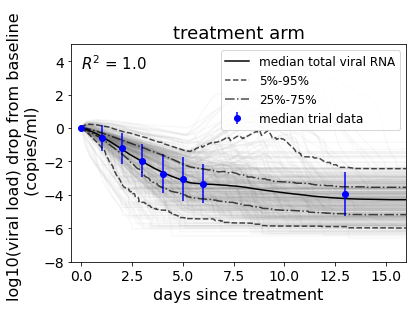

In [217]:
fig, ax1 = plt.subplots(figsize=(6, 4))

i= 6
#np.argwhere(np.round(R2_run_trtmnt,2) ==st.mode(np.round(R2_run_trtmnt,2))[0])[0][0]

for idi in range(0,400):
    ax1.plot(np.linspace(0, 15.999, 16000),drop_VL_runs_trtmnt[i][idi], color = 'grey', alpha = 0.05)
perc_5 = np.percentile(drop_VL_runs_trtmnt[i], 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 15.999, 16000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 15.999, 100000))
perc_95 = np.percentile(drop_VL_runs_trtmnt[i], 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 15.999, 16000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 15.999, 100000))
perc_25 = np.percentile(drop_VL_runs_trtmnt[i], 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 15.999, 16000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 15.999, 100000))
perc_75 = np.percentile(drop_VL_runs_trtmnt[i], 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 15.999, 16000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 15.999, 100000))
t1 = np.argwhere(np.linspace(0, 15.999, 16000)>=1)[0][0]
t2 = np.argwhere(np.linspace(0, 15.999, 16000)>=2)[0][0]
t3 = np.argwhere(np.linspace(0, 15.999, 16000)>=3)[0][0]
t4 = np.argwhere(np.linspace(0, 15.999, 16000)>=4)[0][0]
t5 = np.argwhere(np.linspace(0, 15.999, 16000)>=5)[0][0]
t6 = np.argwhere(np.linspace(0, 15.999, 16000)>=6)[0][0]
t7 = np.argwhere(np.linspace(0, 15.999, 16000)>=7)[0][0]
t14 = np.argwhere(np.linspace(0, 15.999, 16000)>=14)[0][0]  



ax1.plot(np.linspace(0, 15.999, 16000), Mean_drop_VL_TotPop_trtmnt_runs[i], color = 'k', label = 'median total viral RNA')
#ax1.plot(np.linspace(0, 15.999, 16000), Mean_drop_VL_active_trtmnt_runs[i], color = 'm', label = 'viable virus')
ax1.errorbar([0,1,2,3,4,5,6,13], Mean_VL_Drop_Trtmnt,yerr = std_VL_Drop_Trtmnt, fmt = 'o', color = 'b', label = 'median trial data')
ax1.plot(np.linspace(0, 15.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
ax1.plot(np.linspace(0, 15.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
ax1.plot(np.linspace(0, 15.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
ax1.plot(np.linspace(0, 15.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)
ax1.text(0,3.5,'$R^2$ = ' + str(round(R2_run_trtmnt[i],2)))
ax1.set_ylabel("log10(viral load) drop from baseline \n (copies/ml)", fontsize=16)
ax1.tick_params(axis="y", labelsize = 14)
ax1.set_xlabel('days since treatment', fontsize=16)
ax1.tick_params(axis="x", labelsize = 14)
ax1.set_ylim([-8, 5])
ax1.set_xlim([-0.5, 16])
ax1.set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
ax1.set_title('treatment arm')
ax1.legend(fontsize="12")
#plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/controlEPIC.png')

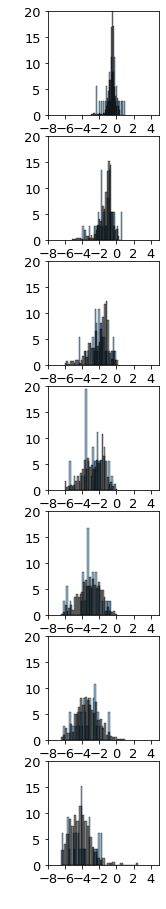

In [218]:
fig = plt.figure(figsize = (2,18))
plt.rcParams.update({'font.size': 13})
P_value = []
for it, t , tindex in zip(range(0, 7), VL_drop_Trtmnt.time.unique(), [t1, t2, t3, t4, t5, t6, t13]):
    Sim = drop_VL_runs_trtmnt[i]
    day = [X[tindex] for X in Sim]
    plt.subplot(8,1, 1+it)
    sns.histplot(VL_drop_Trtmnt[VL_drop_Trtmnt.time == t].VL_Drop, bins=30, color = 'tab:blue', stat = 'percent', kde=False, alpha = 0.5, label = 'data')
    sns.histplot(day, bins = 30, color = 'k', stat = 'percent', kde=False, alpha = 0.5, label = 'simulation')
    start, p = st.kstest(VL_drop_Trtmnt[VL_drop_Trtmnt.time == t].VL_Drop, day)
    P_value.append(p)
   # if p>0.01:
   #     plt.text(1,15, 'p='+str(round(p,2)), fontsize = 15)
   # else:
   #     plt.text(1,15, 'p='+str(round(p,4)), fontsize = 15)
   # if it==0:
      #  plt.legend(loc = (0.75, 0.5))
      #  plt.title('control arm')
    #if it!=3:
    plt.ylabel(' ')
 #   if it!=7:
    plt.xlabel(' ')
  #  else:
    #    plt.xlabel('log_10(VL) drop from baseline')
    plt.xlim([-8,5])   
    plt.xticks(np.linspace(-8,4,7))
    plt.ylim([0,20])
    plt.yticks(np.linspace(0,20,5))
    #sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
#plt.tight_layout(pad=0.002)

In [219]:
Adj_P = []
Adj_P=np.round(st.false_discovery_control(P_value),4)
Adj_P

array([0.1709, 0.6222, 0.5028, 0.7251, 0.6222, 0.7962, 0.5028])